# EEG Sample Processing (BIDS/BrainVision + Muse JSON dumps)

Mirrors the app's processing pipeline for BIDS BrainVision exports (`*_eeg.vhdr` + `*_eeg.eeg` + `*_eeg.json`) or legacy `samples_*.json` files. Loads from `raw_data/`, applies notch + Welch PSD, computes band powers, and renders visuals akin to the app (trace, PSD with band shading, spectrogram, band power bars).


### Guidance

All charts SHALL use the full timestamp range of all available data.
All chart time axes SHALL be rendered in local timezone.


### Diagnostics
- Files loaded, channels per file
- Sample counts per channel
- PSD window count and duration coverage


### Requirements (Reference)

- Device connectivity and data acquisition must preserve channel maps and sampling rates.
- Signal processing uses ~1024-sample windows at ~1 Hz with stable band definitions.
- Band power metrics should be absolute + relative for delta/theta/alpha/beta/gamma.
- Visualizations include raw traces, PSD/spectrograms, and band power trends.
- Resilience: skip processing on insufficient samples; avoid crashes on missing channels.


### Notebook Setup

- Purpose: Initialize dependencies, constants, and input paths.
- Resilience: guard against missing channels or insufficient samples.


In [1]:
from pathlib import Path
from posixpath import expanduser
import json
import re
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import tzlocal
LOCAL_TZ = tzlocal.get_localzone()
print('Local timezone:', LOCAL_TZ)

DEFAULT_FS = 256  # Muse sampling rate
FS = DEFAULT_FS
NPERSEG = 1024  # ~4s windows at 256 Hz
NOVERLAP = NPERSEG // 2
BANDS = [
    {'key': 'delta', 'label': 'Delta', 'min': 0.5, 'max': 4},
    {'key': 'theta', 'label': 'Theta', 'min': 4, 'max': 8},
    {'key': 'alpha', 'label': 'Alpha', 'min': 8, 'max': 12},
    {'key': 'beta', 'label': 'Beta', 'min': 12, 'max': 30},
    {'key': 'gamma', 'label': 'Gamma', 'min': 30, 'max': 50},
]
PSD_AVERAGE = "median"  # best-practice robustness for Welch PSD
BAND_POWER_REJECT_ARTIFACTS = True

# Prefer bundled raw_data if present, otherwise fall back to Downloads (BIDS BrainVision or legacy JSON)
# Artifact detection config (EEG)
ARTIFACT_WINDOW_SEC = 2.0
ARTIFACT_STEP_SEC = 1.0
AMPLITUDE_RANGE_THRESHOLD = 150.0  # units match samples
LINE_NOISE_HZ = 60.0  # set to 50.0 for EU mains
LINE_NOISE_BAND_HZ = 2.0
LINE_NOISE_MAX_HZ = 80.0
LINE_NOISE_RATIO_THRESHOLD = 0.5
PLOT_ARTIFACT_DIAGNOSTICS = True

DEFAULT_SETTINGS = {}
DEFAULT_SETTINGS_PATHS = [Path('public/default_settings.json'), Path('../public/default_settings.json')]
for settings_path in DEFAULT_SETTINGS_PATHS:
    if settings_path.exists():
        DEFAULT_SETTINGS = json.loads(settings_path.read_text())
        print('Loaded default settings from', settings_path)
        break
if DEFAULT_SETTINGS:
    NPERSEG = int(DEFAULT_SETTINGS.get('eegFftWindow', NPERSEG)) or NPERSEG
    NOVERLAP = NPERSEG // 2
    BAND_POWER_AVG_SEC = float(DEFAULT_SETTINGS.get('bandSmoothingSec', 180))
    ARTIFACT_WINDOW_SEC = float(DEFAULT_SETTINGS.get('artifactWindowSec', ARTIFACT_WINDOW_SEC))
    ARTIFACT_STEP_SEC = float(DEFAULT_SETTINGS.get('artifactStepSec', ARTIFACT_STEP_SEC))
    AMPLITUDE_RANGE_THRESHOLD = float(DEFAULT_SETTINGS.get('amplitudeRangeThreshold', AMPLITUDE_RANGE_THRESHOLD))
    LINE_NOISE_HZ = float(DEFAULT_SETTINGS.get('lineNoiseHz', LINE_NOISE_HZ))
    LINE_NOISE_BAND_HZ = float(DEFAULT_SETTINGS.get('lineNoiseBandHz', LINE_NOISE_BAND_HZ))
    LINE_NOISE_MAX_HZ = float(DEFAULT_SETTINGS.get('lineNoiseMaxHz', LINE_NOISE_MAX_HZ))
    LINE_NOISE_RATIO_THRESHOLD = float(DEFAULT_SETTINGS.get('lineNoiseRatioThreshold', LINE_NOISE_RATIO_THRESHOLD))

REJECTION_TRACE_WINDOW_SEC = None  # full session
REJECTION_TRACE_MAX_POINTS = 4000

REJECTION_OVERLAY_MODE = 'always'  # 'auto', 'always', or 'off'
REJECTION_OVERLAY_MAX_WINDOWS = 200

RAW_DIR_CANDIDATES = [Path('notebooks/raw_data'), Path('raw_data'), Path(expanduser('~/Downloads/'))]
RAW_FILE_PATTERNS = ['samples_*.json', '*_eeg.json', '*_eeg.vhdr']
RAW_DIR = None
for candidate in RAW_DIR_CANDIDATES:
    if not candidate.exists():
        continue
    for pattern in RAW_FILE_PATTERNS:
        if any(candidate.glob(pattern)):
            RAW_DIR = candidate
            break
    if RAW_DIR is not None:
        break
if RAW_DIR is None:
    RAW_DIR = RAW_DIR_CANDIDATES[0]


Local timezone: America/Los_Angeles
Loaded default settings from ../public/default_settings.json


### Kernel Dependencies

- Purpose: Ensure scipy is available in the active kernel and report versions.
- Resilience: guard against missing channels or insufficient samples.


In [2]:
import sys
import subprocess

# Ensure scipy is installed for the active notebook kernel
try:
    import scipy  # noqa: F401
except Exception:
    print("Installing scipy into:", sys.executable)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy"])
    import scipy  # noqa: F401

print("Kernel Python:", sys.executable)
print("scipy version:", scipy.__version__)


Kernel Python: /Users/matthewtippett/.pyenv/versions/3.14.2/bin/python
scipy version: 1.17.0


### EEG Utilities

- Purpose: Load EEG processing utilities for downstream analysis.
- Resilience: guard against missing channels or insufficient samples.


In [3]:
if "eeg" not in globals():
    import sys
    from pathlib import Path
    _utils_dir = Path('notebooks')
    if (_utils_dir / 'eeg_processing_utils.py').exists():
        sys.path.insert(0, str(_utils_dir.resolve()))
    import eeg_processing_utils as eeg


### Artifact Detection (Amplitude Range + Line Noise)


### Artifact Rejection Diagnostics (Per Trace)


### Load EEG Exports

- Purpose: Load EEG exports, summarize diagnostics, and apply any stored config.
- Dependency: `eeg_processing_utils` loaded as `eeg`.
- Inputs: `exports`/`diag_df` available; handle empty data safely.
- Resilience: guard against missing channels or insufficient samples.


In [4]:

exports = eeg.load_sample_exports(RAW_DIR, pattern=None)
diag_df = eeg.build_export_diagnostics(exports)
eeg.print_export_summary(diag_df, RAW_DIR)

# Apply exported config if present
config = {}
if exports:
    config = (exports[0].get("_sidecar") or {}).get("Config") or {}
if config:
    if "eegFftWindow" in config:
        NPERSEG = int(config["eegFftWindow"]) or NPERSEG
        NOVERLAP = NPERSEG // 2
    if "artifactWindowSec" in config:
        ARTIFACT_WINDOW_SEC = float(config["artifactWindowSec"])
    if "artifactStepSec" in config:
        ARTIFACT_STEP_SEC = float(config["artifactStepSec"])
    if "amplitudeRangeThreshold" in config:
        AMPLITUDE_RANGE_THRESHOLD = float(config["amplitudeRangeThreshold"])
    if "lineNoiseHz" in config:
        LINE_NOISE_HZ = float(config["lineNoiseHz"])
    if "lineNoiseBandHz" in config:
        LINE_NOISE_BAND_HZ = float(config["lineNoiseBandHz"])
    if "lineNoiseMaxHz" in config:
        LINE_NOISE_MAX_HZ = float(config["lineNoiseMaxHz"])
    if "lineNoiseRatioThreshold" in config:
        LINE_NOISE_RATIO_THRESHOLD = float(config["lineNoiseRatioThreshold"])
    if "bandSmoothingSec" in config:
        BAND_POWER_AVG_SEC = float(config["bandSmoothingSec"])
    if "spectrogramWindowSec" in config:
        MAX_SPECTROGRAM_SEC = int(config["spectrogramWindowSec"])

    # Keep helper module aligned with updated settings
    eeg.NPERSEG = NPERSEG
    eeg.NOVERLAP = NOVERLAP
    eeg.LINE_NOISE_HZ = LINE_NOISE_HZ

    print("Applied config from export:", config)

# Enforce full-session plotting per notebook guidance
MAX_SPECTROGRAM_SEC = None
REJECTION_TRACE_WINDOW_SEC = None


=== Sample Export Summary ===
RAW_DIR: raw_data
Files: 11
Total channels: 44
Channel labels: ['AF7', 'AF8', 'TP10', 'TP9']
CapturedAt range: 2026-01-25T21:14:37.624000+00:00 → 2026-01-25T21:24:37.640000+00:00
CaptureEndedAt range: 2026-01-25T21:15:37.616254+00:00 → 2026-01-25T21:25:37.632254+00:00
Sampling rates (Hz): [256.0163850486431]
Samples/channel (min/median/max): 15360 / 15360 / 15360
Duration/channel seconds (min/median/max): 60.00 / 60.00 / 60.00
Timestamps present (per-sample): 0/44 channels
Applied config from export: {'bandWindowSec': 300, 'bandSmoothingSec': 60, 'deltaSmoothingSec': 20, 'spectrogramWindowSec': 300, 'eegTraceWindow': 4096, 'eegFftWindow': 1024, 'ppgTraceWindow': 1024, 'notchHz': 50, 'spectrogramUseCachedSlices': True, 'artifactWindowSec': 2, 'artifactStepSec': 1, 'amplitudeRangeThreshold': 150, 'lineNoiseHz': 60, 'lineNoiseBandHz': 2, 'lineNoiseMaxHz': 80, 'lineNoiseRatioThreshold': 0.5, 'rejectionOverlayMode': 'auto', 'rejectionOverlayMaxWindows': 200}


### Artifact Rejection + Metrics

- Purpose: Plot EEG traces with artifact overlays and artifact metric diagnostics.
- Dependency: `eeg_processing_utils` loaded as `eeg`.
- Inputs: `exports`/`diag_df` available; handle empty data safely.
- Charts: full-session timestamp range with local-time axes.
- Resilience: guard against missing channels or insufficient samples.


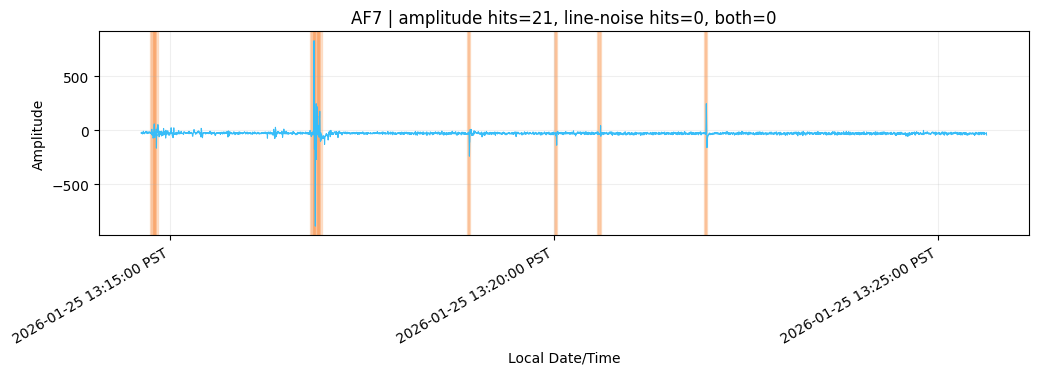

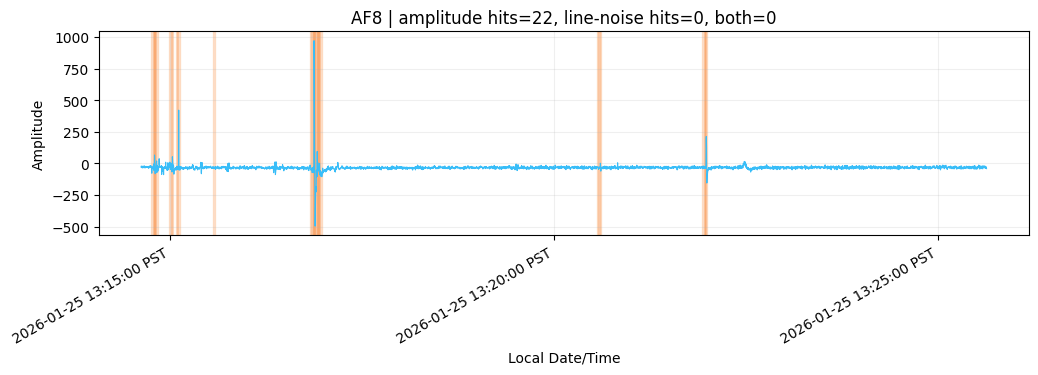

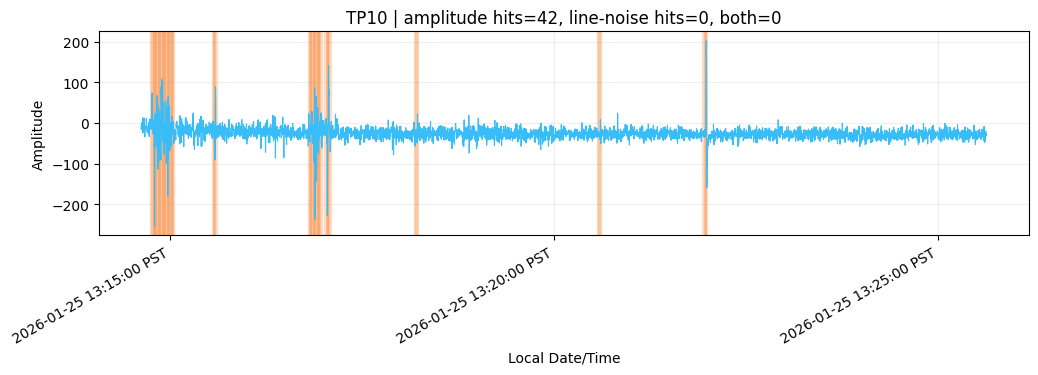

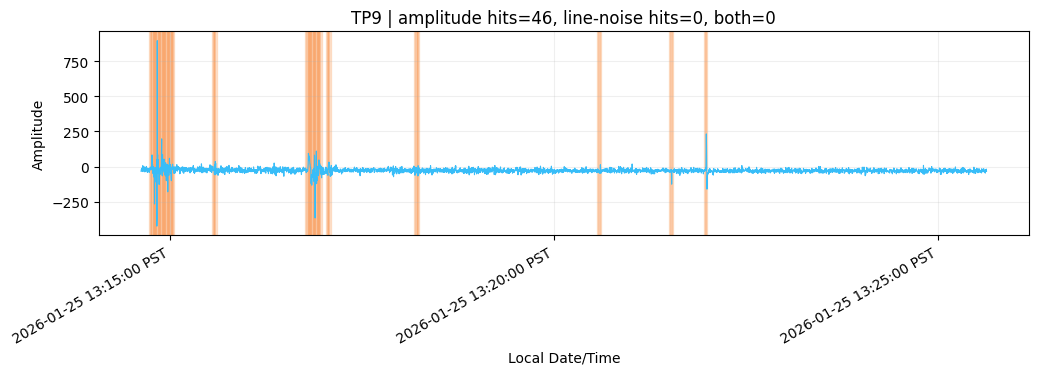

Artifact rates by label (% of windows):
       amplitude_artifact_rate  line_noise_artifact_rate  artifact_rate
label                                                                  
TP9                        7.0                       0.0            7.0
TP10                       6.4                       0.0            6.4
AF8                        3.3                       0.0            3.3
AF7                        3.2                       0.0            3.2


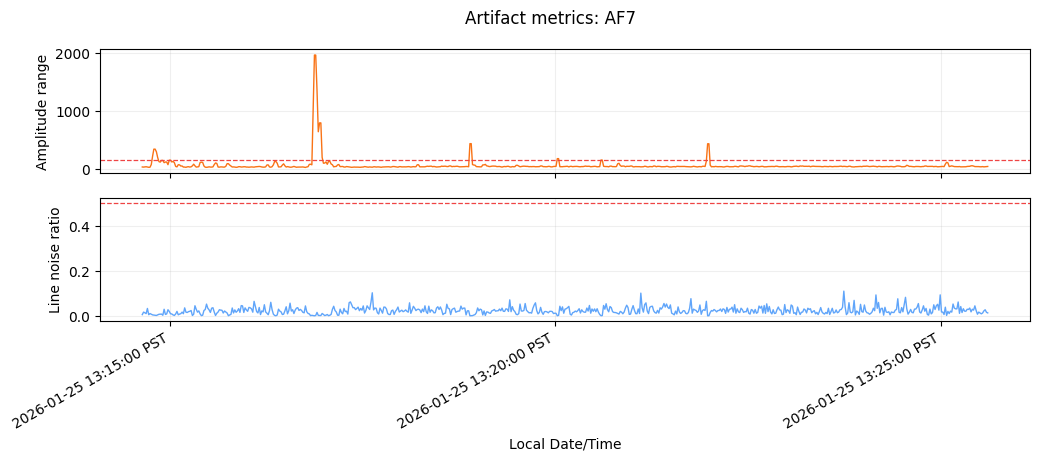

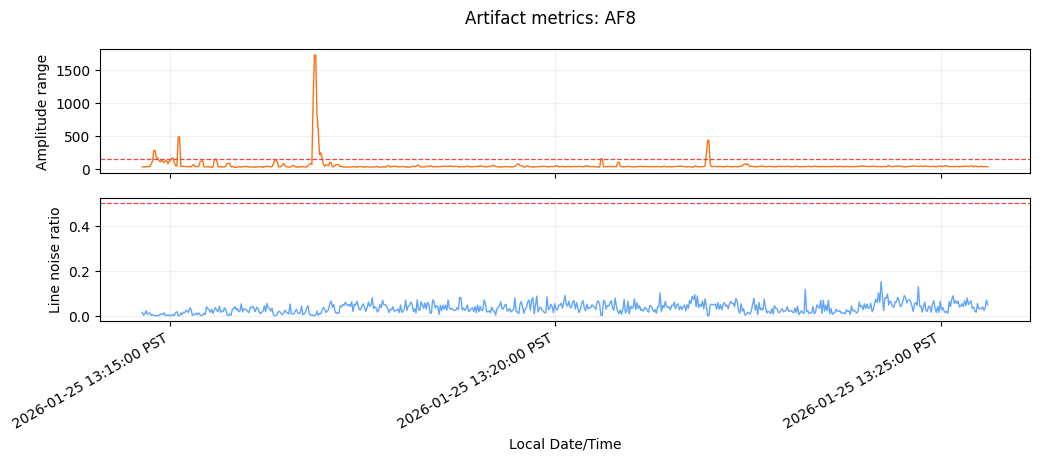

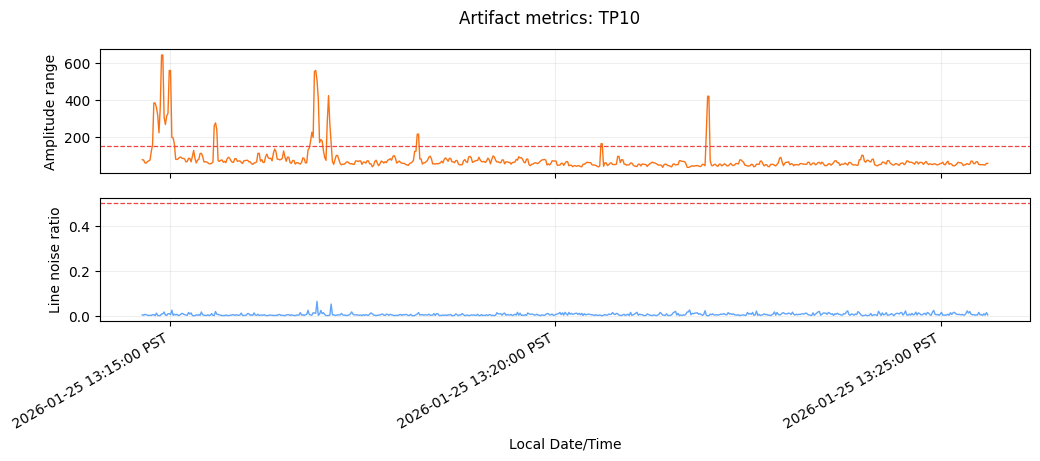

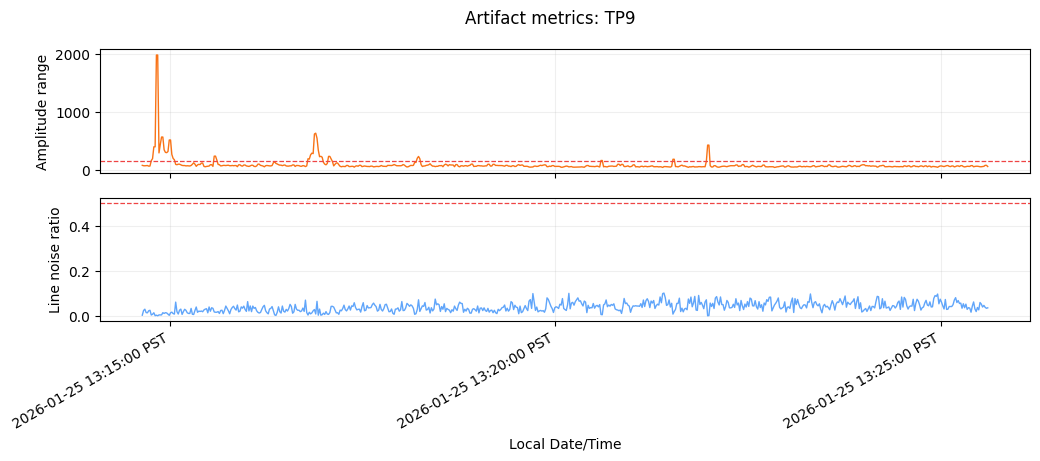

In [5]:
# Artifact rejection overlays + metrics
artifact_df = eeg.plot_artifact_overlays_and_metrics(
    exports,
    diag_df,
    window_sec=ARTIFACT_WINDOW_SEC,
    step_sec=ARTIFACT_STEP_SEC,
    amplitude_range_threshold=AMPLITUDE_RANGE_THRESHOLD,
    line_noise_ratio_threshold=LINE_NOISE_RATIO_THRESHOLD,
    line_noise_hz=LINE_NOISE_HZ,
    line_noise_band_hz=LINE_NOISE_BAND_HZ,
    line_noise_max_hz=LINE_NOISE_MAX_HZ,
    overlay_mode=REJECTION_OVERLAY_MODE,
    overlay_max_windows=REJECTION_OVERLAY_MAX_WINDOWS,
    trace_window_sec=REJECTION_TRACE_WINDOW_SEC,
    trace_max_points=REJECTION_TRACE_MAX_POINTS,
    plot_diagnostics=PLOT_ARTIFACT_DIAGNOSTICS,
)


### Raw PPG Traces
Plots raw PPG channels from the exported TSV files.

### Load PPG Exports

- Purpose: Load PPG exports and print diagnostics.
- Dependency: `eeg_processing_utils` loaded as `eeg`.
- Inputs: `ppg_exports` available; skip if missing.
- Resilience: guard against missing channels or insufficient samples.


In [6]:
ppg_exports = eeg.load_ppg_exports(RAW_DIR, pattern='*_ppg.tsv')
if ppg_exports:
    ppg_diag_df = eeg.build_export_diagnostics(ppg_exports)
    eeg.print_export_summary(ppg_diag_df, RAW_DIR)
else:
    ppg_diag_df = None
    print('No PPG exports found in', RAW_DIR)


=== Sample Export Summary ===
RAW_DIR: raw_data
Files: 11
Total channels: 22
Channel labels: ['PPG1', 'PPG2']
CapturedAt range: 2026-01-25T21:14:37.624000+00:00 → 2026-01-25T21:24:37.640000+00:00
CaptureEndedAt range: 2026-01-25T21:15:37.608375+00:00 → 2026-01-25T21:25:37.624375+00:00
Sampling rates (Hz): [64.0]
Samples/channel (min/median/max): 3840 / 3840 / 3840
Duration/channel seconds (min/median/max): 60.00 / 60.00 / 60.00
Timestamps present (per-sample): 0/22 channels


### Raw PPG Traces

- Purpose: Plot full-session raw PPG traces for each channel.
- Dependency: `eeg_processing_utils` loaded as `eeg`.
- Inputs: `ppg_exports` available; skip if missing.
- Charts: full-session timestamp range with local-time axes.
- Resilience: guard against missing channels or insufficient samples.


Plotting window: 2026-01-25 13:14:37 PST to 2026-01-25 13:25:37 PST


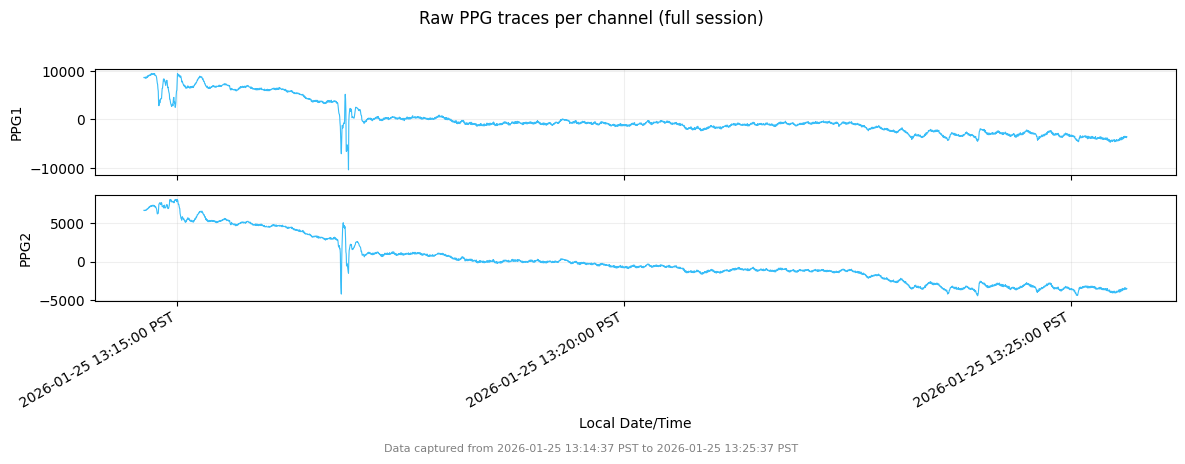

In [7]:
if ppg_exports:
    PPG_WINDOW_SEC = 10
    PPG_MAX_POINTS = 3000
    PPG_FIG_WIDTH = 12
    eeg.plot_raw_traces_per_label(
        ppg_exports,
        diag_df=ppg_diag_df,
        window_sec=PPG_WINDOW_SEC,
        max_points=PPG_MAX_POINTS,
        fig_width=PPG_FIG_WIDTH,
        title_prefix='PPG',
    )
else:
    print('Skipping PPG trace plot (no data).')


### PPG Cardiogram + Heart Rate (15s average)
Processes the combined PPG into a cardiogram-like signal and plots a 15-second averaged HR trend.

### EEG Utilities

- Purpose: Load EEG processing utilities for downstream analysis.
- Dependency: `eeg_processing_utils` loaded as `eeg`.
- Inputs: `exports`/`diag_df` available; handle empty data safely.
- Inputs: `ppg_exports` available; skip if missing.
- Charts: full-session timestamp range with local-time axes.
- Resilience: guard against missing channels or insufficient samples.


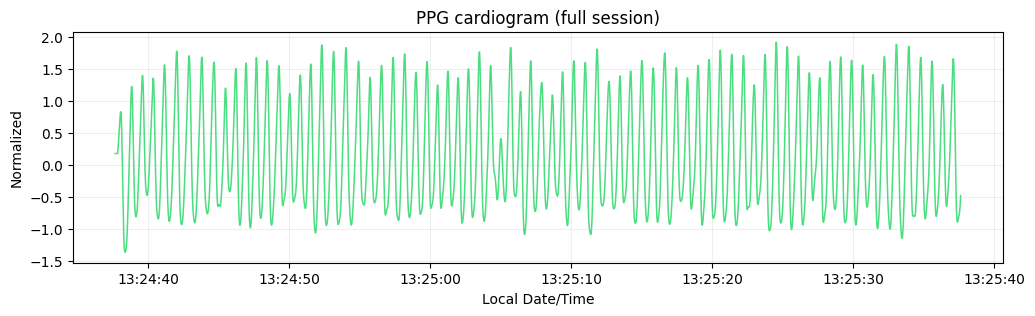

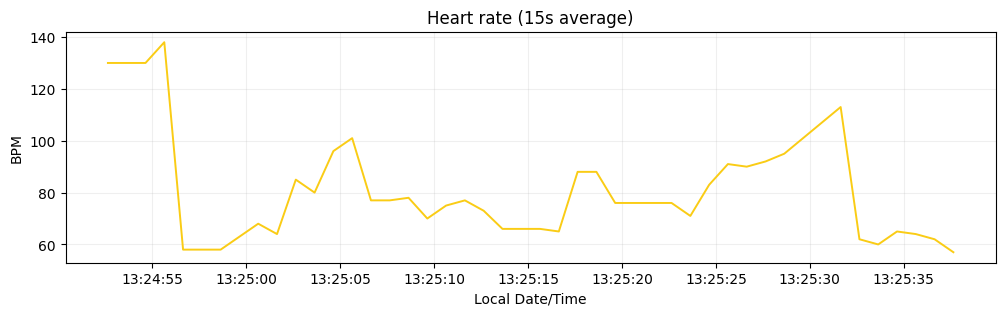

In [8]:
if "eeg" not in globals():
    import sys
    from pathlib import Path
    _utils_dir = Path('notebooks')
    if (_utils_dir / 'eeg_processing_utils.py').exists():
        sys.path.insert(0, str(_utils_dir.resolve()))
    import eeg_processing_utils as eeg

if "ppg_exports" not in globals():
    ppg_exports = eeg.load_ppg_exports(RAW_DIR, pattern='*_ppg.tsv')

if ppg_exports:
    ppg_export = ppg_exports[-1]
    ppg_combined, ppg_fs = eeg.combine_ppg_channels(ppg_export)
    if ppg_combined is None:
        print('No combined PPG data available.')
    else:
        capture_start = eeg.export_capture_start(ppg_export)
        if capture_start is None:
            print('Skipping PPG cardiogram/HR plots (missing capture start for local time).')
        else:
            cardiogram = eeg.process_ppg_cardiogram(ppg_combined, ppg_fs)
            t_sec = np.arange(len(cardiogram)) / ppg_fs
            ts = eeg.to_local_datetime_index(
                pd.Series(pd.to_datetime(capture_start, utc=True) + pd.to_timedelta(t_sec, unit='s'))
            )
            plt.figure(figsize=(12, 3))
            plt.plot(ts, cardiogram, color='#4ade80', linewidth=1.1)
            plt.title('PPG cardiogram (full session)')
            plt.xlabel('Local Date/Time')
            plt.ylabel('Normalized')
            plt.grid(alpha=0.2)
            plt.show()

            hr_df = eeg.heart_rate_series(ppg_combined, ppg_fs, window_sec=15, step_sec=1)
            if hr_df.empty:
                print('No HR series available for plotting.')
            else:
                plt.figure(figsize=(12, 3))
                ts_hr = eeg.to_local_datetime_index(
                    pd.Series(pd.to_datetime(capture_start, utc=True) + pd.to_timedelta(hr_df['t_sec'], unit='s'))
                )
                plt.plot(ts_hr, hr_df['bpm'], color='#facc15', linewidth=1.4)
                plt.title('Heart rate (15s average)')
                plt.xlabel('Local Date/Time')
                plt.ylabel('BPM')
                plt.grid(alpha=0.2)
                plt.show()
else:
    print('Skipping PPG cardiogram/HR plots (no data).')


### Spectrograms (Per Electrode)

Computes a spectrogram for each channel label and renders them as stacked time–frequency heatmaps.


### Spectrograms

- Purpose: Compute and plot full-session spectrograms per electrode.
- Dependency: `eeg_processing_utils` loaded as `eeg`.
- Inputs: `exports`/`diag_df` available; handle empty data safely.
- Charts: full-session timestamp range with local-time axes.
- Resilience: guard against missing channels or insufficient samples.


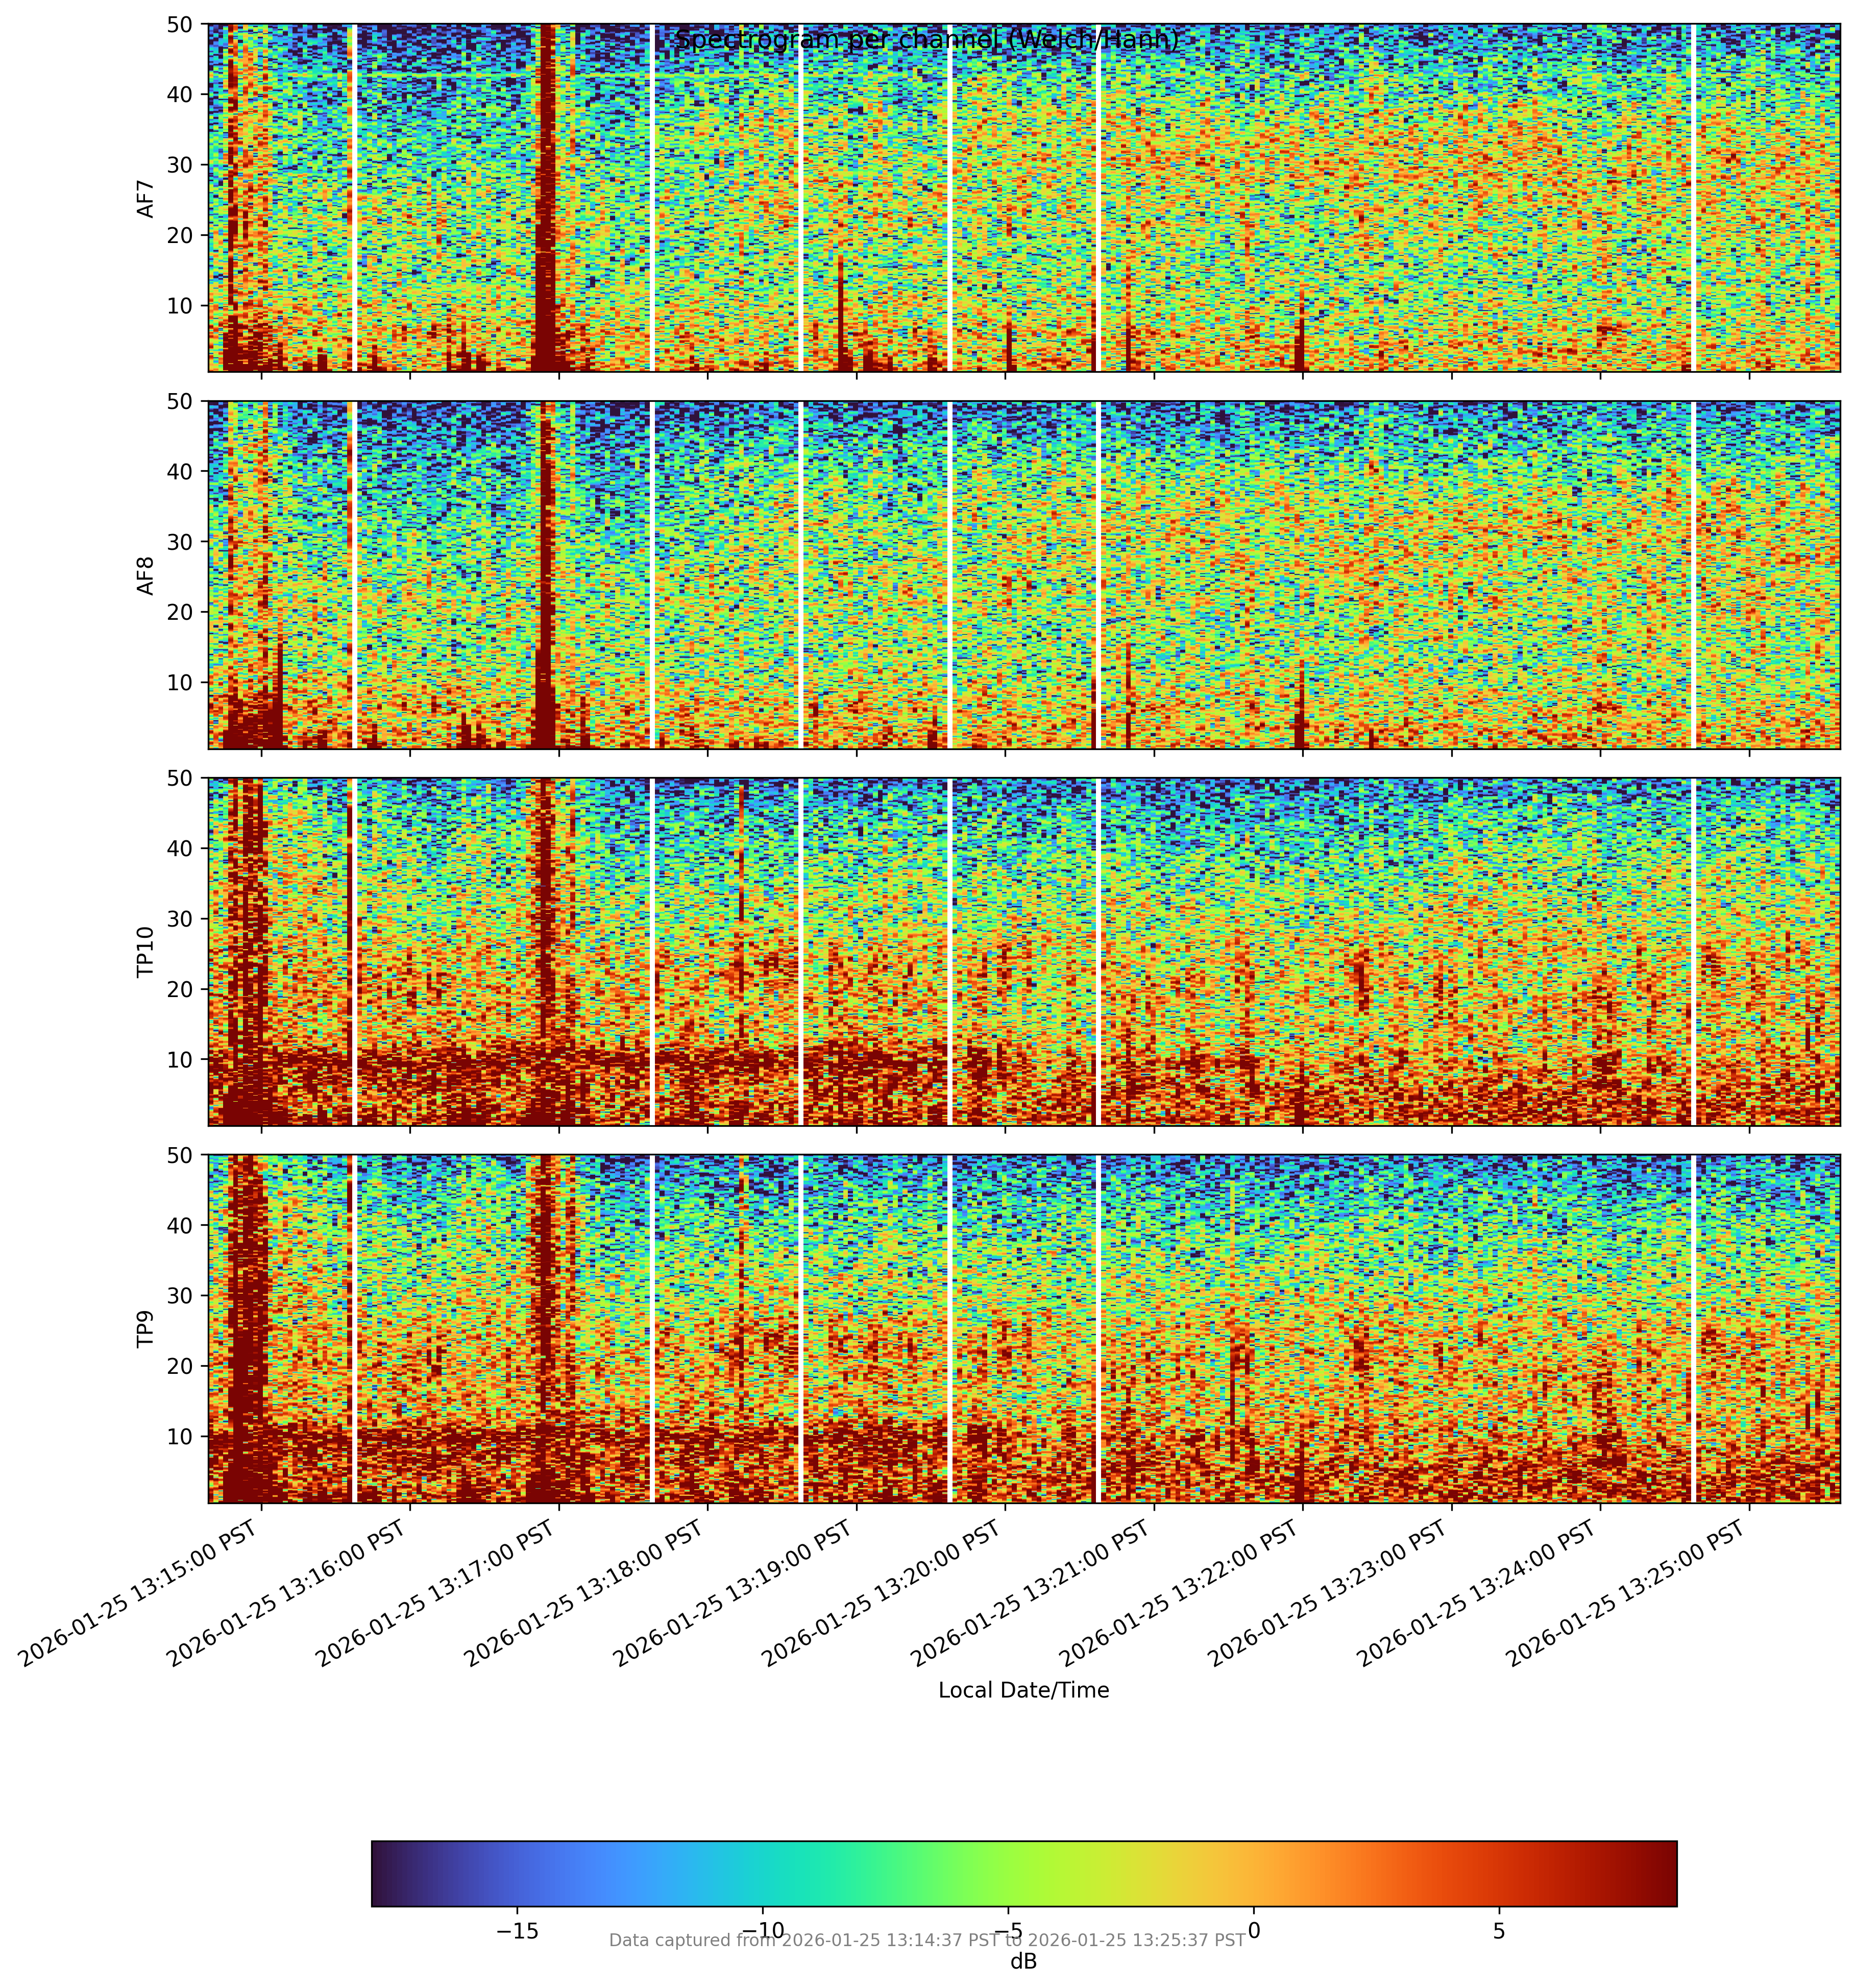

In [9]:
# Spectrograms per electrode channel
MAX_SPECTROGRAM_SEC = MAX_SPECTROGRAM_SEC if 'MAX_SPECTROGRAM_SEC' in globals() else None
# Keep spectrogram windows aligned with band power settings for comparable views.
SPECTROGRAM_NPERSEG = NPERSEG
SPECTROGRAM_NOVERLAP = NOVERLAP
# Note: `nfft` zero-pads (smoother grid) but doesn't add true frequency resolution.
SPECTROGRAM_NFFT = max(4096, SPECTROGRAM_NPERSEG)
SPECTROGRAM_ROW_HEIGHT = 3.2  # inches per channel
SPECTROGRAM_DPI = 300
FIG_WIDTH = 12
eeg.plot_spectrograms_per_label(
    exports,
    diag_df=diag_df,
    max_spectrogram_sec=MAX_SPECTROGRAM_SEC,
    max_freq_hz=50,
    nfft=SPECTROGRAM_NFFT,
    nperseg=SPECTROGRAM_NPERSEG,
    noverlap=SPECTROGRAM_NOVERLAP,
    per_channel_height=SPECTROGRAM_ROW_HEIGHT,
    dpi=SPECTROGRAM_DPI,
    fig_width=FIG_WIDTH,
)


### Band Power Diagrams

Creates band power line charts for each electrode, TP channels combined, AF channels combined, and all channels combined.


### Band Power Diagrams

- Purpose: Compute band power time series and plot per-channel and grouped views.
- Dependency: `eeg_processing_utils` loaded as `eeg`.
- Inputs: `exports`/`diag_df` available; handle empty data safely.
- Charts: full-session timestamp range with local-time axes.
- Resilience: guard against missing channels or insufficient samples.


Band power plot window for AF7: 2026-01-25 13:14:39 PST to 2026-01-25 13:25:35 PST
Band power plot window for AF8: 2026-01-25 13:14:39 PST to 2026-01-25 13:25:35 PST
Band power plot window for TP10: 2026-01-25 13:14:39 PST to 2026-01-25 13:25:35 PST
Band power plot window for TP9: 2026-01-25 13:14:39 PST to 2026-01-25 13:25:35 PST
Band power plot window for TP Combined: 2026-01-25 13:14:39 PST to 2026-01-25 13:25:35 PST
Band power plot window for AF Combined: 2026-01-25 13:14:39 PST to 2026-01-25 13:25:35 PST
Band power plot window for Left Combined: 2026-01-25 13:14:39 PST to 2026-01-25 13:25:35 PST
Band power plot window for Right Combined: 2026-01-25 13:14:39 PST to 2026-01-25 13:25:35 PST
Band power plot window for All Combined: 2026-01-25 13:14:39 PST to 2026-01-25 13:25:35 PST


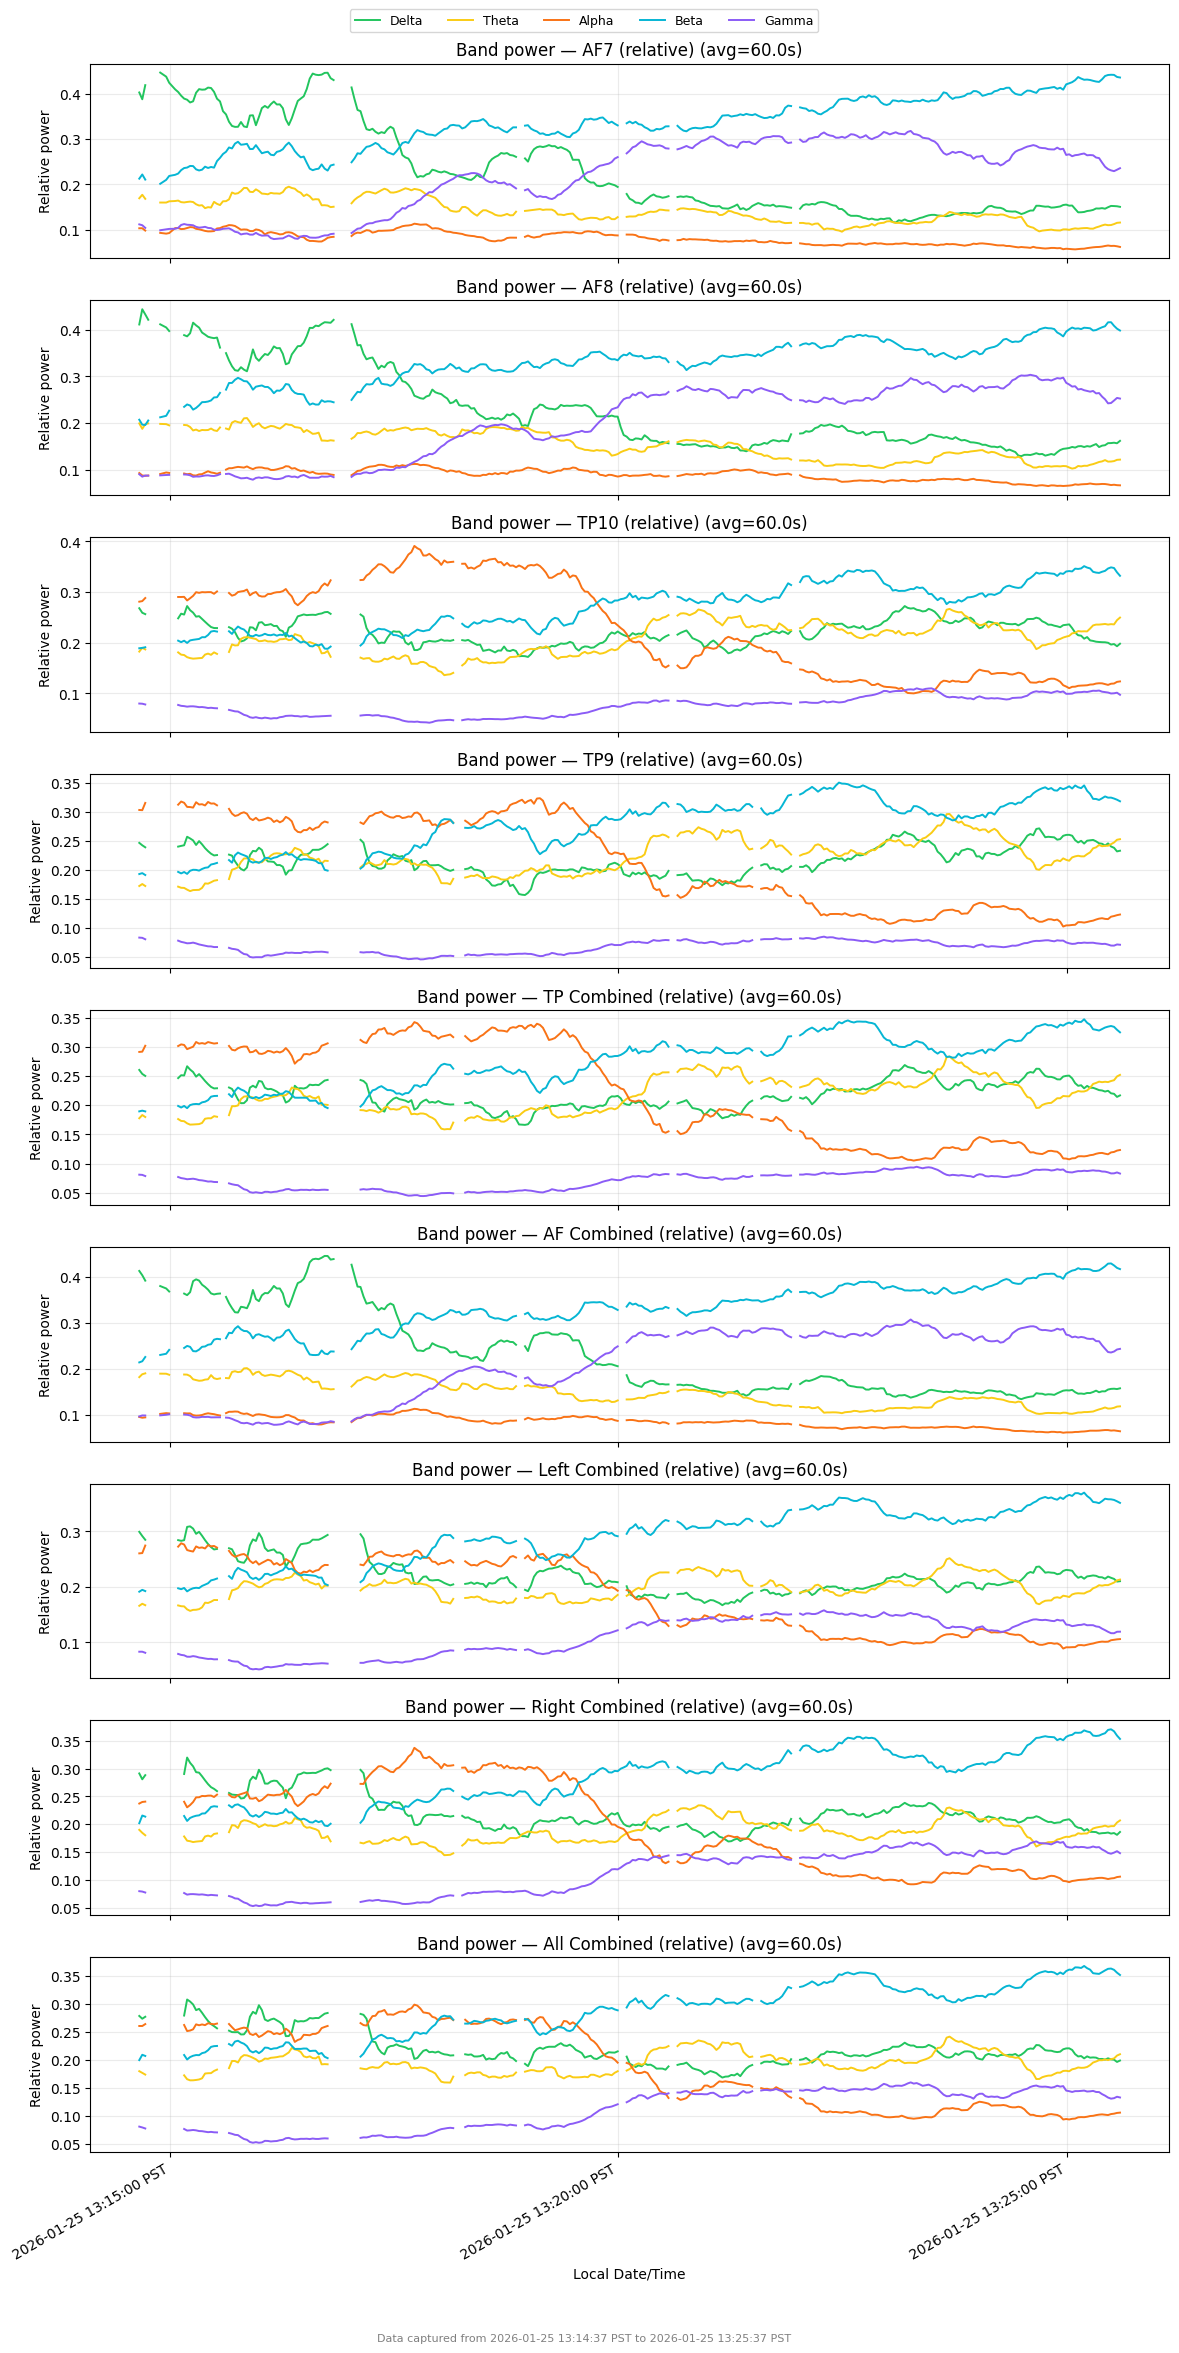

In [10]:
# Band power diagrams: per channel + combined groups
BAND_POWER_AVG_SEC = BAND_POWER_AVG_SEC if 'BAND_POWER_AVG_SEC' in globals() else 180
PLOT_RELATIVE = True
FIG_WIDTH = 12

_ = eeg.plot_band_power_diagrams(
    exports,
    diag_df,
    avg_sec=BAND_POWER_AVG_SEC,
    relative=PLOT_RELATIVE,
    fig_width=FIG_WIDTH,
    reject_artifacts=BAND_POWER_REJECT_ARTIFACTS,
    amplitude_range_threshold=AMPLITUDE_RANGE_THRESHOLD,
    line_noise_ratio_threshold=LINE_NOISE_RATIO_THRESHOLD,
    line_noise_hz=LINE_NOISE_HZ,
    line_noise_band_hz=LINE_NOISE_BAND_HZ,
    line_noise_max_hz=LINE_NOISE_MAX_HZ,
    nfft=SPECTROGRAM_NFFT,
)
